In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from scipy import stats

In [2]:
# Load the data
df_0 = pd.read_csv(r"C:\Users\pingk\Downloads\fadhli nitip\asik_NIR_1.csv")


In [3]:
# Define the regions of interest
regions_of_interest = [
    (4641, 4681), (4867, 5510), (5657, 5826), (7057, 7097),
    (7169, 7209), (8238, 8278)
]

# Extract columns corresponding to the regions of interest
columns_to_focus = []
for start, end in regions_of_interest:
    columns_to_focus.extend([col for col in df_0.columns[4:-5] if start <= float(col) <= end])

In [4]:
target = 'thnoth_name'

# Train a RandomForest model to get feature importances
X = df_0[columns_to_focus]
y = df_0[target]

In [5]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

RandomForestClassifier(random_state=42)

In [6]:
# Get feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[-15:]  # Top 15 features

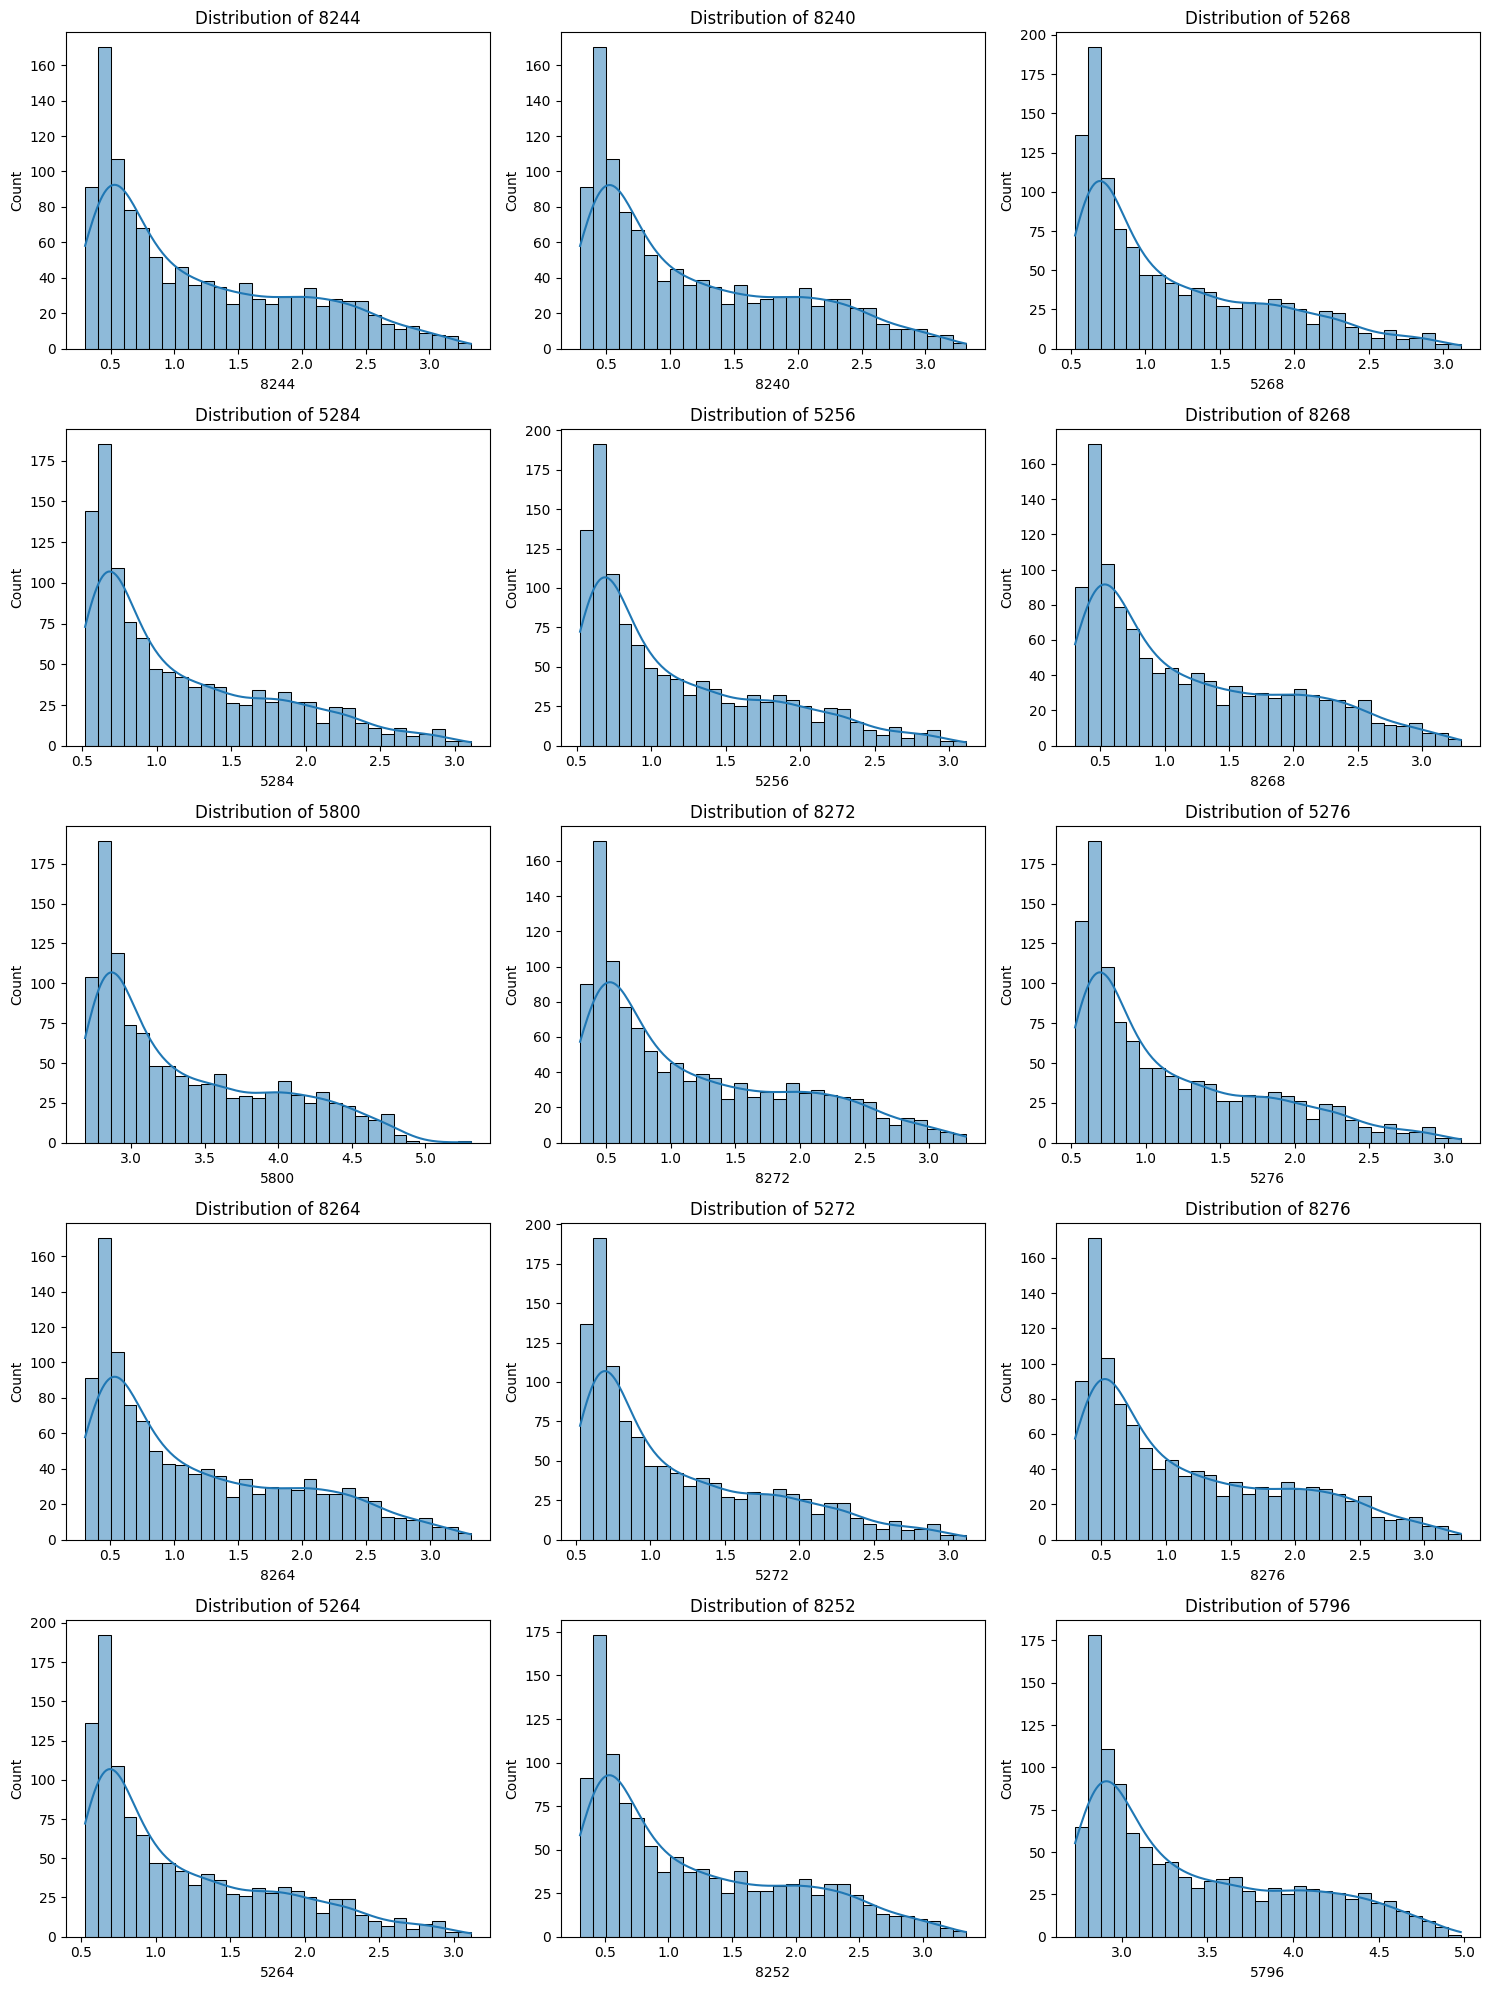

In [7]:
# Plot the distribution of the top 15 most important features
plt.figure(figsize=(15, 20))
for i, idx in enumerate(indices):
    plt.subplot(5, 3, i + 1)
    sns.histplot(df_0[columns_to_focus[idx]], bins=30, kde=True)
    plt.title(f'Distribution of {columns_to_focus[idx]}')
plt.tight_layout()
plt.show()

In [8]:
# Define a function to remove outliers using Z-score
def remove_outliers_zscore(df, columns, threshold=3):
    z_scores = np.abs(stats.zscore(df[columns]))
    return df[(z_scores < threshold).all(axis=1)]

# Remove outliers from the top 15 important features
top_features = [columns_to_focus[idx] for idx in indices]
df_0_cleaned = remove_outliers_zscore(df_0, top_features)

# Check the shape of the cleaned dataframe
print("Original Data Shape:", df_0.shape)
print("Cleaned Data Shape:", df_0_cleaned.shape)

Original Data Shape: (1156, 1907)
Cleaned Data Shape: (1152, 1907)


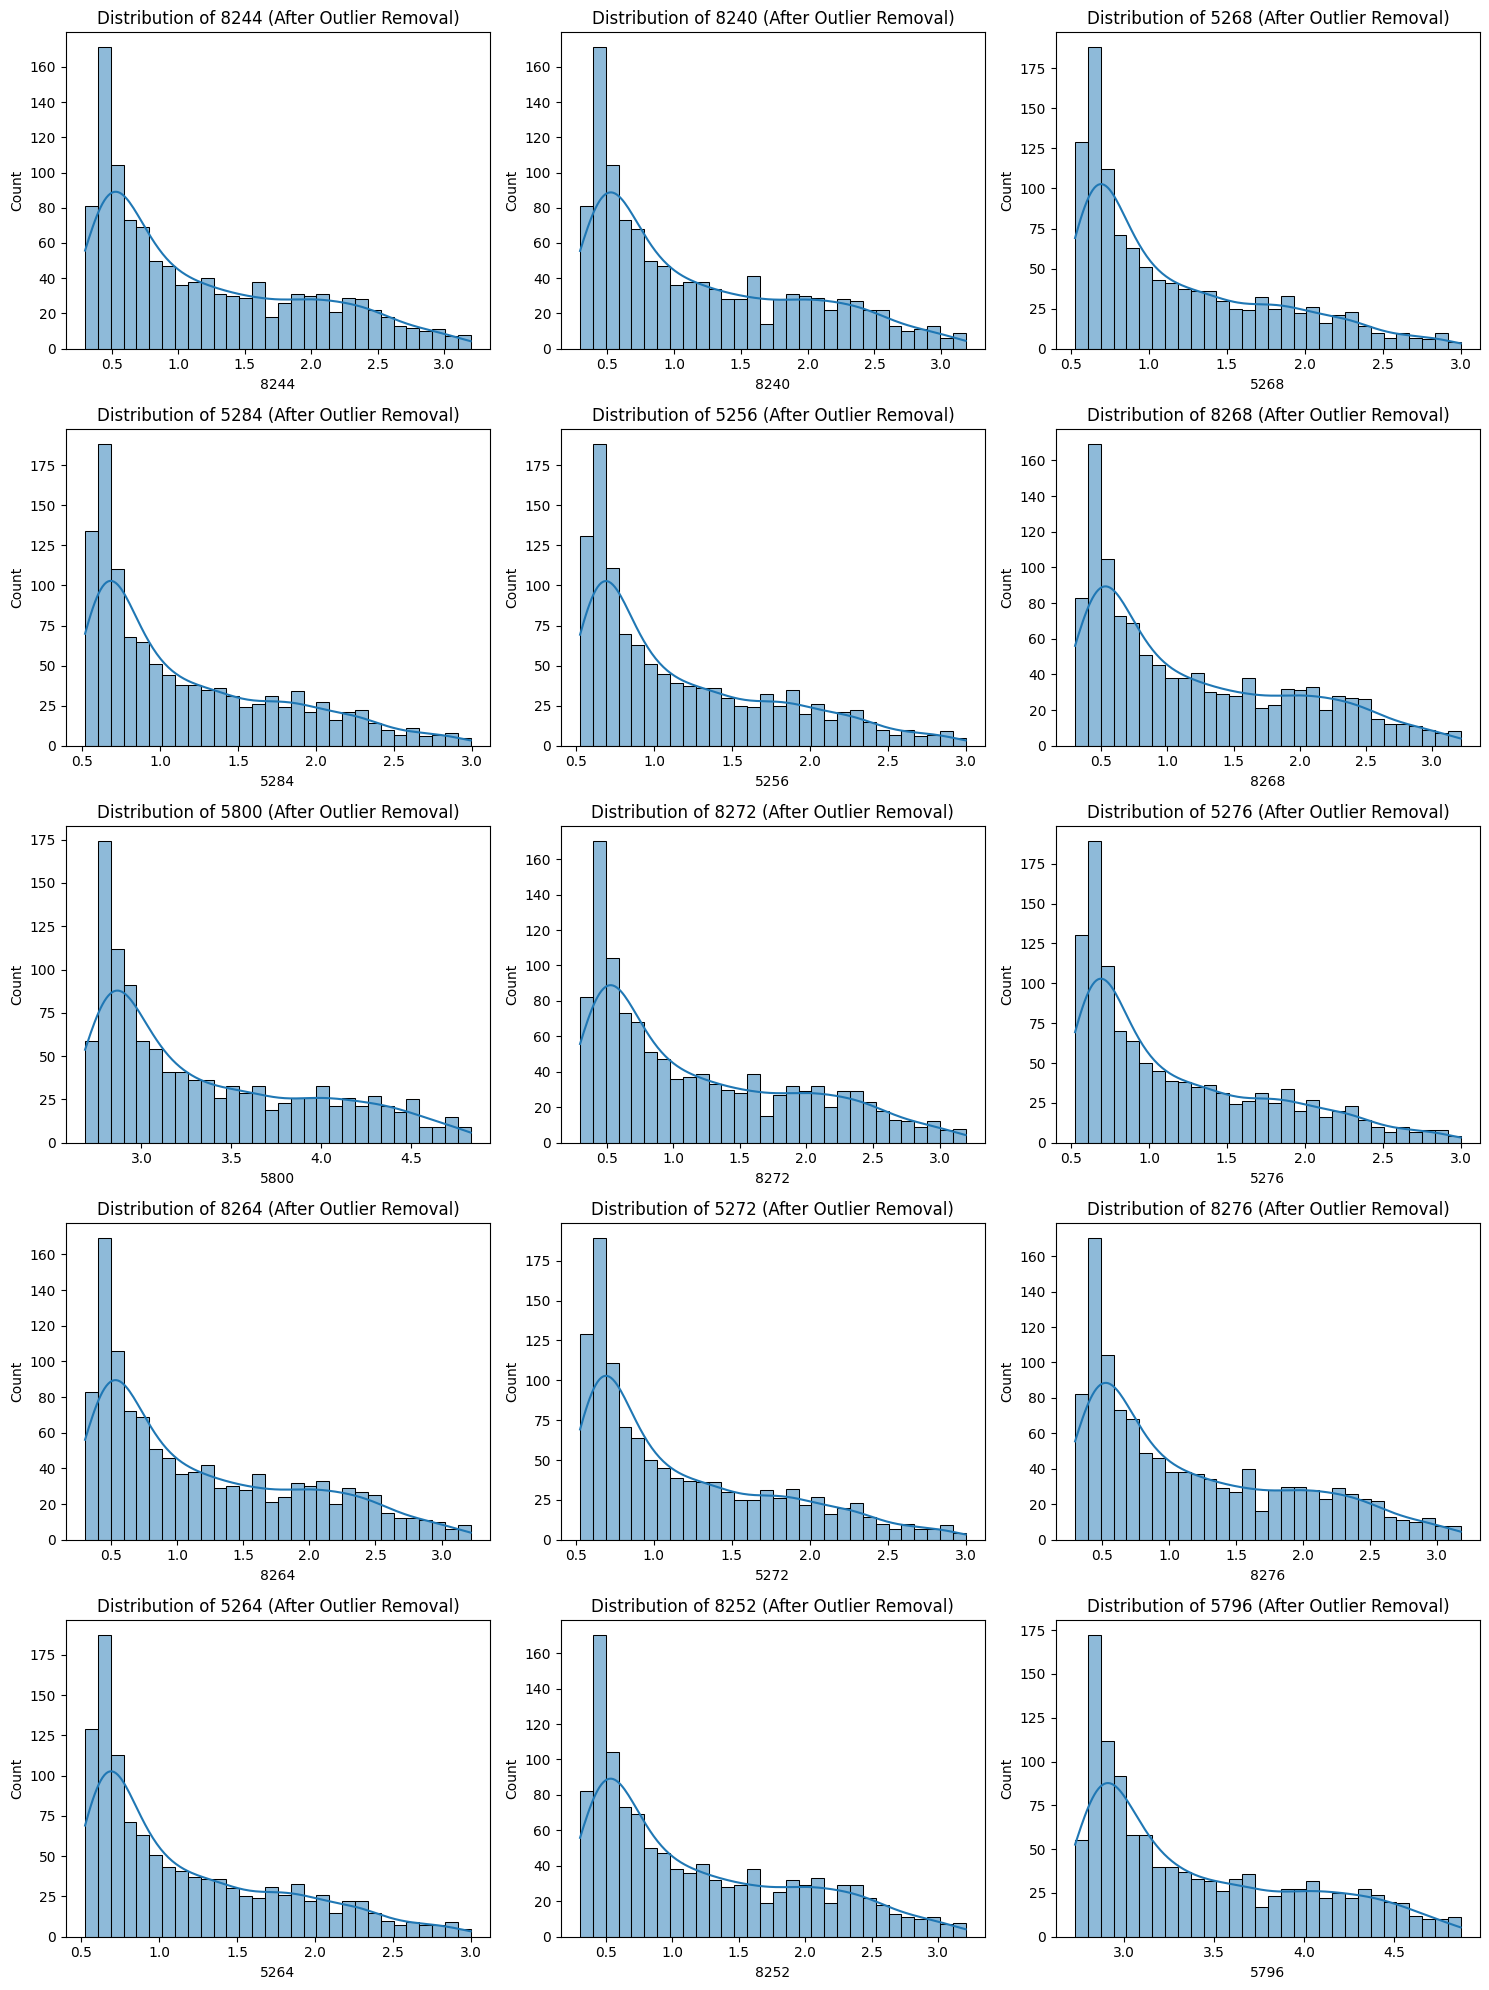

In [9]:
# Plot the distribution of the top 15 most important features after outlier removal
plt.figure(figsize=(15, 20))
for i, feature in enumerate(top_features):
    plt.subplot(5, 3, i + 1)
    sns.histplot(df_0_cleaned[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature} (After Outlier Removal)')
plt.tight_layout()
plt.show()


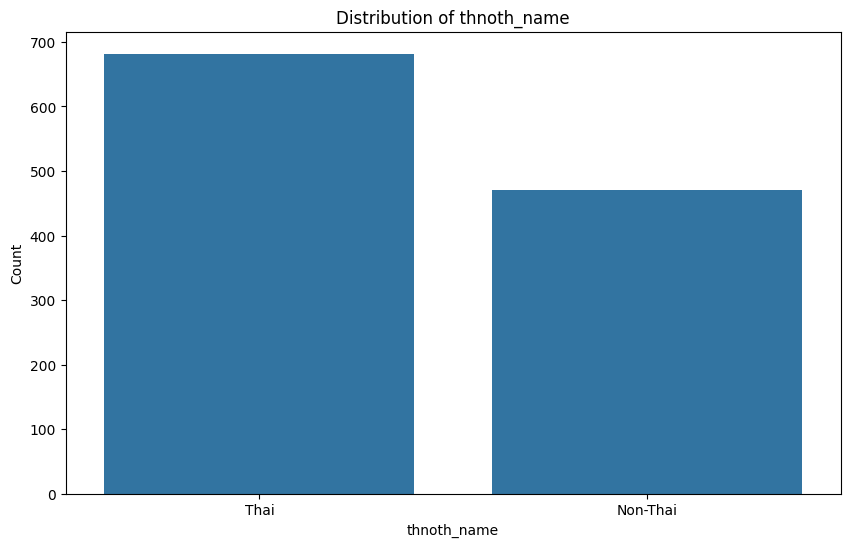

In [10]:
# Create a distribution plot for 'thnoth_name'
plt.figure(figsize=(10, 6))
sns.countplot(data=df_0_cleaned, x=target)
plt.title('Distribution of thnoth_name')
plt.xlabel('thnoth_name')
plt.ylabel('Count')
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Split the cleaned data into train and test sets
X_cleaned = df_0_cleaned[columns_to_focus]
y_cleaned = df_0_cleaned[target]

X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.7, random_state=42)

# Train the RandomForest model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Analyze accuracy per 'prov_char'
df_0_test_cleaned = df_0_cleaned.loc[X_test.index]
df_0_test_cleaned['predicted'] = y_pred
df_0_test_cleaned['actual'] = y_test.values

prov_char_analysis = df_0_test_cleaned.groupby('prov_char').apply(lambda x: (x['actual'] == x['predicted']).mean())
print(prov_char_analysis)


Classification Report:
               precision    recall  f1-score   support

    Non-Thai       0.48      0.46      0.47       315
        Thai       0.66      0.69      0.68       492

    accuracy                           0.60       807
   macro avg       0.57      0.57      0.57       807
weighted avg       0.59      0.60      0.60       807

Confusion Matrix:
 [[144 171]
 [153 339]]
prov_char
BBX    0.484848
CBI    0.769231
CCO    0.750000
CPN    0.708861
KAX    0.333333
KBI    0.690722
KBX    0.531250
KTX    0.636364
NRT    0.766667
NWT    0.636364
RIX    0.414815
SGR    0.444444
SNI    0.676647
SNK    0.714286
SUX    0.315789
TRG    0.646154
dtype: float64


C:\Users\pingk\AppData\Local\Temp\ipykernel_27400\2537884486.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  prov_char_analysis = df_0_test_cleaned.groupby('prov_char').apply(lambda x: (x['actual'] == x['predicted']).mean())


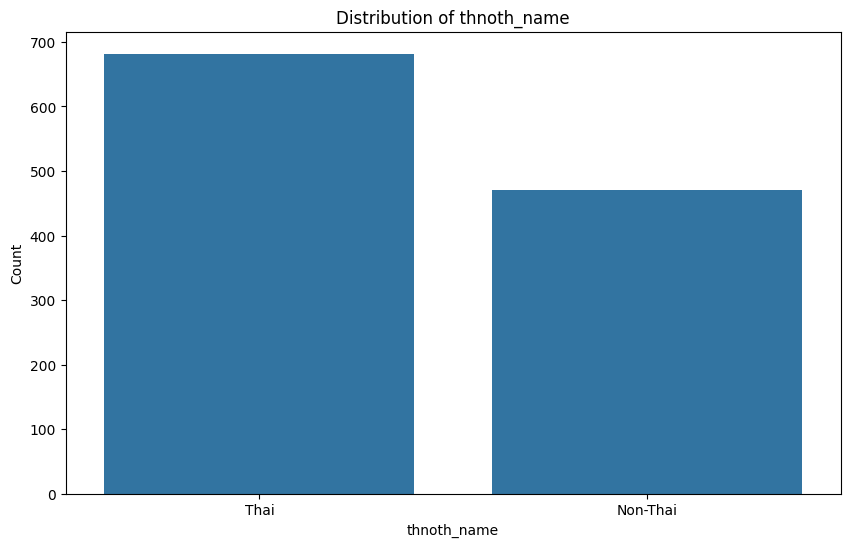

In [12]:
# Create a distribution plot for 'thnoth_name'
plt.figure(figsize=(10, 6))
sns.countplot(data=df_0_cleaned, x=target)
plt.title('Distribution of thnoth_name')
plt.xlabel('thnoth_name')
plt.ylabel('Count')
plt.show()

In [13]:
# Verify the new distribution
print("New distribution of thnoth_name:")
print(df_0_cleaned[target].value_counts())

New distribution of thnoth_name:
thnoth_name
Thai        682
Non-Thai    470
Name: count, dtype: int64


In [14]:
# Separate Thai and Non-Thai samples
df_0_cleaned_thai = df_0_cleaned[df_0_cleaned[target] == 'Thai']
df_0_cleaned_non_thai = df_0_cleaned[df_0_cleaned[target] == 'Non-Thai']

In [15]:
from sklearn.ensemble import IsolationForest

# Identify and remove outliers in Thai samples using Isolation Forest
iso = IsolationForest(contamination=0.1, random_state=42)
yhat = iso.fit_predict(df_0_cleaned_thai[columns_to_focus])
mask = yhat != -1
df_0_cleaned_thai_cleaned = df_0_cleaned_thai[mask]

In [16]:
# Combine the cleaned Thai samples with Non-Thai samples

df_1_cleaned = pd.concat([df_0_cleaned_thai_cleaned, df_0_cleaned_non_thai], axis=0).reset_index(drop=True)

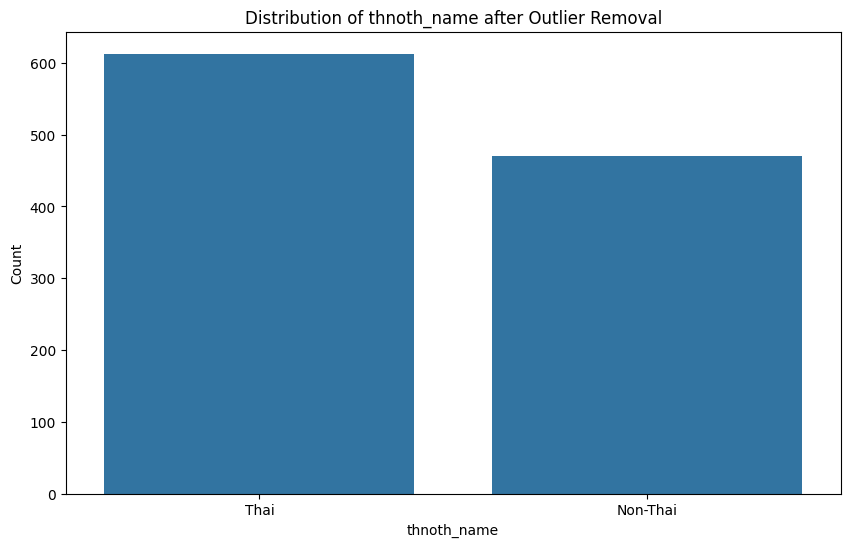

In [17]:
# Plot the distribution of thnoth_name after outlier removal
plt.figure(figsize=(10, 6))
sns.countplot(data=df_1_cleaned, x=target)
plt.title('Distribution of thnoth_name after Outlier Removal')
plt.xlabel('thnoth_name')
plt.ylabel('Count')
plt.show()


In [18]:
#df_1_cleaned.to_csv(r"C:\Users\pingk\Downloads\fadhli nitip\asik_rt4_now with indo new_cleaned.csv", index=False)

In [19]:
# Verify the new distribution
print("New distribution of thnoth_name:")
print(df_1_cleaned[target].value_counts())

New distribution of thnoth_name:
thnoth_name
Thai        613
Non-Thai    470
Name: count, dtype: int64


In [20]:
df_2 = df_1_cleaned.copy()

In [21]:
from sklearn.preprocessing import LabelEncoder

# Encoding the 'thnoth_name' column
le = LabelEncoder()
df_2['thnoth_name_encoded'] = le.fit_transform(df_2['thnoth_name'])

In [22]:
# Define the target variable and numeric columns
numeric_cols_df_2 = df_2.select_dtypes(include=[np.number]).columns.tolist()
string_cols_df_2 = df_2.select_dtypes(exclude=[np.number]).columns.tolist()

# Drop non-numeric columns and target column from numeric columns list
numeric_cols_df_2 = [col for col in numeric_cols_df_2 if col not in string_cols_df_2]

In [23]:
# Train a RandomForest model to get feature importances
X_df_2 = df_2[numeric_cols_df_2].drop(columns=['thnoth_name_encoded'])
y_df_2 = df_2['thnoth_name_encoded'].values

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler

# Initial model training to find consistent samples
rf = RandomForestClassifier(random_state=42)
rf.fit(X_df_2, y_df_2)

# Get predictions
df_2['predictions'] = rf.predict(X_df_2)

# Keep samples that are correctly classified
consistent_samples = df_2[df_2['thnoth_name_encoded'] == df_2['predictions']]

# Separate features and target again with consistent samples
X_df_2_consistent = consistent_samples.drop(columns=['thnoth_name', 'thnoth_name_encoded', 'predictions'])
y_df_2_consistent = consistent_samples['thnoth_name_encoded'].values

# Ensure X_df_2_consistent contains only numeric columns
X_df_2_consistent = X_df_2_consistent.select_dtypes(include=[np.number])

# Map for original string labels to numeric encoded labels
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# Step 8: Apply undersampling to achieve a balanced dataset
rus = RandomUnderSampler(sampling_strategy={label_mapping['Thai']: 470, label_mapping['Non-Thai']: 470}, random_state=42)
X_df_2_balanced, y_df_2_balanced = rus.fit_resample(X_df_2_consistent, y_df_2_consistent)

# Step 9: Display the new distribution of 'thnoth_name'
balanced_df = consistent_samples.iloc[rus.sample_indices_]
thnoth_name_distribution = balanced_df['thnoth_name'].value_counts()
print(thnoth_name_distribution)


thnoth_name
Non-Thai    470
Thai        470
Name: count, dtype: int64


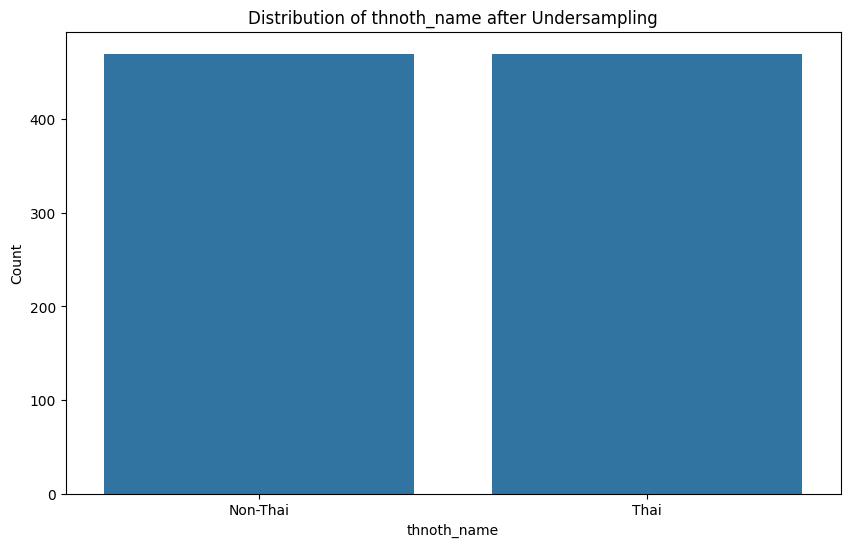

In [25]:
# Check the distribution of 'thnoth_name' after undersampling

import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of 'thnoth_name'
plt.figure(figsize=(10, 6))
sns.countplot(data=balanced_df, x='thnoth_name')
plt.title('Distribution of thnoth_name after Undersampling')
plt.xlabel('thnoth_name')
plt.ylabel('Count')
plt.show()


In [26]:
balanced_df.drop(columns=['predictions'], inplace=True)

C:\Users\pingk\AppData\Local\Temp\ipykernel_27400\902976214.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  balanced_df.drop(columns=['predictions'], inplace=True)


In [27]:
balanced_df.reset_index(drop=True, inplace=True)

Mean Accuracy: 0.5509799963678236
Left out group: ['BBX'], Accuracy: 0.35555555555555557
Left out group: ['CBI'], Accuracy: 0.6923076923076923
Left out group: ['CCO'], Accuracy: 0.6923076923076923
Left out group: ['CPN'], Accuracy: 0.6575342465753424
Left out group: ['KAX'], Accuracy: 0.42857142857142855
Left out group: ['KBI'], Accuracy: 0.5161290322580645
Left out group: ['KBX'], Accuracy: 0.4316546762589928
Left out group: ['KTX'], Accuracy: 0.6666666666666666
Left out group: ['NRT'], Accuracy: 0.7692307692307693
Left out group: ['NWT'], Accuracy: 0.68
Left out group: ['RIX'], Accuracy: 0.2822966507177033
Left out group: ['SGR'], Accuracy: 0.7222222222222222
Left out group: ['SNI'], Accuracy: 0.46540880503144655
Left out group: ['SNK'], Accuracy: 0.16666666666666666
Left out group: ['SUX'], Accuracy: 0.7407407407407407
Left out group: ['TRG'], Accuracy: 0.5483870967741935


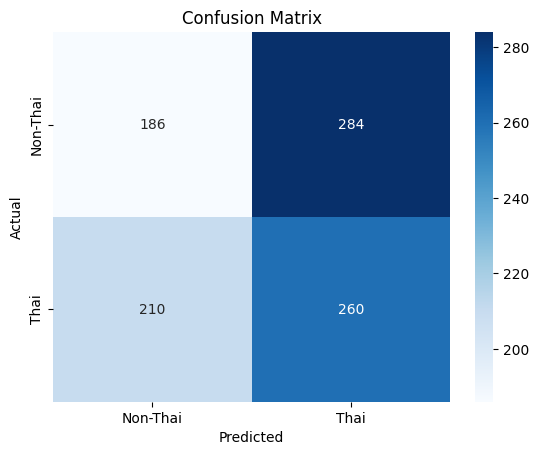

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize and encode the 'prov_char' column
le_prov = LabelEncoder()
prov_char_encoded = le_prov.fit_transform(balanced_df['prov_char'])

# Define features and target for the balanced dataset
X_balanced = balanced_df.drop(columns=['thnoth_name', 'thnoth_name_encoded'])
y_balanced = balanced_df['thnoth_name_encoded'].values

# Ensure X_balanced contains only numeric columns
X_balanced = X_balanced.select_dtypes(include=[np.number])

# Initialize LOGO-CV
logo = LeaveOneGroupOut()

# Arrays to store results
accuracies = []
left_out_groups = []
all_y_test = []
all_y_pred = []

# Perform LOGO-CV
for train_idx, test_idx in logo.split(X_balanced, y_balanced, groups=prov_char_encoded):
    X_train, X_test = X_balanced.iloc[train_idx], X_balanced.iloc[test_idx]
    y_train, y_test = y_balanced[train_idx], y_balanced[test_idx]
    
    # Train the model
    rf.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Store results
    accuracies.append(accuracy)
    left_out_groups.append(balanced_df['prov_char'].iloc[test_idx].unique())
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)

# Calculate mean accuracy
mean_accuracy = np.mean(accuracies)
print(f'Mean Accuracy: {mean_accuracy}')

# Display left out groups and their accuracies
for group, acc in zip(left_out_groups, accuracies):
    print(f'Left out group: {group}, Accuracy: {acc}')

# Generate confusion matrix
conf_matrix = confusion_matrix(all_y_test, all_y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [29]:
balanced_df.head()

,prov_char,country_char,wavenumber,11544,11540,11536,11532,11528,11524,11520,...,3964,3960,3956,3952,tgp_name,dgp_name,fgp_name,country_name,thnoth_name,thnoth_name_encoded
0,KAX,ID,ID-KAX-088-2401-001,0.290252,0.290122,0.290044,0.290029,0.290042,0.289978,0.289851,...,3.558086,3.542757,3.530849,3.501222,Group 3,Group 2,Group 4,Indonesia,Non-Thai,0
1,KBX,ID,ID-KBX-068-2306-003,0.522845,0.522798,0.522826,0.522669,0.522414,0.522217,0.522070,...,3.680422,3.655416,3.629388,3.606223,Group 3,Group 2,Group 4,Indonesia,Non-Thai,0
2,BBX,ID,ID-BBX-095-2401-004,-0.144108,-0.144008,-0.143893,-0.143777,-0.143686,-0.143667,-0.143678,...,3.650478,3.623180,3.614590,3.581875,Group 3,Group 2,Group 3,Indonesia,Non-Thai,0
3,SUX,ID,ID-SUX-074-2311-001,0.333905,0.333777,0.333785,0.333700,0.333522,0.333453,0.333446,...,3.601331,3.566453,3.539593,3.512285,Group 3,Group 2,Group 3,Indonesia,Non-Thai,0
4,SUX,ID,ID-SUX-073-2311-001,1.522433,1.521460,1.521133,1.521072,1.521494,1.522300,1.521840,...,4.103365,4.125110,4.113971,4.055192,Group 3,Group 2,Group 3,Indonesia,Non-Thai,0


In [30]:
balanced_df.to_csv(r"C:\Users\pingk\Downloads\fadhli nitip\asik_NIR_DIST_3b.csv", index=False)